## Loading Data and Modules

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible
pd.set_option('display.max_columns', None)  # No limit on number of columns displayed

import pickle  # Pickle dataframe to use in other project file

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample  # For handling class imbalances

import xgboost as xgb  # Gradient boosting classifier

In [2]:
# Unpickle the df
with open('rideshare_df_100pct.pkl', 'rb') as picklefile: 
    df = pickle.load(picklefile)

## Remove Destination Columns
Destination columns don't contribute to surge pricing, so no need to include them

In [3]:
df = pd.concat([df.iloc[:, 0:12], df.iloc[:, 24:]], axis=1)

## Fix Duplicate Lyft Columns

In [4]:
# Rename 'Lyft' ride type to 'Lyft Basic'
# 'Lyft' (service) is unchanged

df1 = df.iloc[:, 0:29]
df2 = df.iloc[:, 29:]
df2.rename(columns={'Lyft': 'Lyft Basic'}, inplace=True)
df = pd.concat([df1, df2], axis=1)
df.head(1)

,distance,surge_multiplier,day,day_minutes,temp,clouds,pressure,rain,humidity,wind,Lyft,Uber,Back Bay,Beacon Hill,Boston University,Fenway,Financial District,Haymarket Square,North End,North Station,Northeastern University,South Station,Theatre District,West End,Black,Black SUV,Lux,Lux Black,Lux Black XL,Lyft Basic,Lyft XL,Shared,Taxi,UberPool,UberX,UberXL,WAV,december,november,fri,mon,sat,sun,thu,tue,wed
0,1.22,0,29.0,193.0,38.07,0.8,1000.94,0.0,0.69,9.86,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


## Create DF for Feature Testing

In [5]:
# df_features_eng is a copy of df. Used to manipulate features
df_feature_eng = df.copy()

## Feature Engineer - Examine Recent Rides

We have no overlap on day numbers between November and December:

In [6]:
df_feature_eng.groupby(['december', 'day']).size()

december  day 
0         25.0      504
          26.0    47931
          27.0    63173
          28.0    94544
          29.0    44581
          30.0    45396
1         1.0     44928
          2.0     44928
          3.0     44772
          4.0      3432
          9.0      4447
          12.0     3120
          13.0    44771
          14.0    44928
          15.0    44928
          16.0    44928
          17.0    44928
          18.0    26832
dtype: int64

Trying to find cab rides in the past recent_minutes

### Add `recent_rides` column

In [7]:
# Re-add 'location' column using the dummy variable location columns
def get_location_column(df):
    locations = ['Back Bay', 'Beacon Hill', 'Boston University', 'Fenway', 'Financial District',
                   'Haymarket Square', 'North End', 'North Station', 'Northeastern University',
                    'South Station', 'Theatre District', 'West End']
    
    # Create df where the location columns are all stacked as an index
    df_loc = df[locations].stack()
    
    # Find the location for every row, reset index, then drop columns 'level_0' and 0
    df_loc = df_loc[df_loc == 1].reset_index().drop(['level_0',0],axis=1)
    
    # Concat location column back to df
    df_return = pd.concat([df, df_loc], axis=1)
    
    # Rename new column to 'location'
    df_return.rename(columns = {'level_1': 'location'}, inplace=True)
    
    return df_return

In [8]:
# Insert column 'num_recent_rides' for every row. Represents number of rides that have occurred
# within the past 'recent_ride_time'

def get_recent_rides(df, recent_ride_time):
    
    locations = ['Back Bay', 'Beacon Hill', 'Boston University', 'Fenway', 'Financial District',
                   'Haymarket Square', 'North End', 'North Station', 'Northeastern University',
                   'South Station', 'Theatre District', 'West End']
    
    df = get_location_column(df)
    
    for location in locations:
        
        # Create df_ride_data to contain the info we need from df
        df_ride_data = df[['Uber', 'day', 'day_minutes', 'location']]

        # If 1 in column, it's an Uber. If 0, a Lyft
        df_ride_data.rename(columns={'Uber': 'uber1_lyft0'}, inplace=True)
        
        # Find all rows where location is 'location'
        df_ride_data = df_ride_data[df_ride_data.location == location]
    
        # Merge df_ride_data with itself on columns 'location', 'day', and 'uber1_lyft0'
        df_merged = df_ride_data.merge(df_ride_data, on=['uber1_lyft0', 'location', 'day'])
    
        # Find all occurrences in df_merged where the time difference between the current ride and 
        # the last is < 'recent_ride_time' mins
        # Current and last ride are both Uber/Lyft, at the same location, and at the same day
        df_time_diff = df_merged[
            ((df_merged.day_minutes_x - df_merged.day_minutes_y) < recent_ride_time) & 
            ((df_merged.day_minutes_x - df_merged.day_minutes_y) > 0)]
        
        # Groupby location, whether it's Uber/Lyft, day, and the day_minutes
        df_recent_rides = df_time_diff.groupby(['location', 'uber1_lyft0', 'day', 'day_minutes_x']).count().reset_index()
        
        # Rename columns so that we can merge data back into df
        df_recent_rides.rename(columns={'day_minutes_x': 'day_minutes'}, inplace=True)
        df_recent_rides.rename(columns={'day_minutes_y': 'num_recent_rides'}, inplace=True)
        df_recent_rides.rename(columns={'uber1_lyft0': 'Uber'}, inplace=True)
        
        # Merge df of recent rides back into df
        df_merged_recent_rides = df.merge(df_recent_rides, on=['location', 'Uber', 'day', 'day_minutes'])
        
        # Keep building up the return_df for each iteration
        if location == 'Back Bay':
            return_df = df_merged_recent_rides
        else:
            return_df = pd.concat([return_df, df_merged_recent_rides])
    
    # Drop the 'location' column that was added, so that we only have dummy variable location columns
    return_df.drop(columns='location', inplace=True)
    
    return return_df


In [9]:
# Get num_recent_rides in the past 10 minutes
# Do it for every ride
df_feature_eng = get_recent_rides(df, 10)

/Users/samad/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


## Feature Engineer - Circular Time

In [10]:
# Make time on a continuous scale (23:59 goes to 24:00)
df_feature_eng['day_minutes_sin'] = np.sin(df_feature_eng.day_minutes*(2.*np.pi/1440))  # 1440 mins in a day
df_feature_eng['day_minutes_cos'] = np.cos(df_feature_eng.day_minutes*(2.*np.pi/1440))
df_feature_eng.drop(['day_minutes'], axis=1, inplace=True)

## Feature Engineer - Weather

In [11]:
# Drop 'temp' and 'wind' since the pairplot distributions for surge and no surge are very similar for them
df_feature_eng.drop(['temp', 'wind'], axis=1, inplace=True)

## Feature Engineer - Game Day

In [12]:
# Create a game_day column, and write '1' if there's a celtics/patriots game that day
def get_game_day(day):
    
    # Set of game days (celtics and/or patriots)
    game_days = {30, 2, 14, 16}
    
    if day in game_days:
        return 1
    else:
        return 0

In [13]:
# Create game_day column
df_feature_eng['game_day'] = df_feature_eng.day.apply(get_game_day)

# Train Test Split Dataset
_NOTE: Always split into train, test, and validation data before handling class imbalance using under/oversampling!_

In [14]:
# Split data into train and test sets. 80/20 split
X_train_val, X_test, y_train_val, y_test = train_test_split(df_feature_eng.drop(['surge_multiplier'], axis=1),  # Features are everything
                                                                                                    # except 'surge_multiplier'
                                                    df_feature_eng['surge_multiplier'],  # Target data is 'surge_multiplier' (1/0)
                                                    test_size = 0.2, random_state=4444)

In [15]:
# Split data into val and train sets. 80/20 split
X_train, X_val, y_train, y_val = train_test_split(X_train_val,  # Features are everything except 'surge_multiplier'
                                                  y_train_val,  # Target data is 'surge_multiplier' (1/0)
                                                  test_size = 0.2, random_state=4444)

In [16]:
X_train.columns

Index(['distance', 'day', 'clouds', 'pressure', 'rain', 'humidity', 'Lyft',
       'Uber', 'Back Bay', 'Beacon Hill', 'Boston University', 'Fenway',
       'Financial District', 'Haymarket Square', 'North End', 'North Station',
       'Northeastern University', 'South Station', 'Theatre District',
       'West End', 'Black', 'Black SUV', 'Lux', 'Lux Black', 'Lux Black XL',
       'Lyft Basic', 'Lyft XL', 'Shared', 'Taxi', 'UberPool', 'UberX',
       'UberXL', 'WAV', 'december', 'november', 'fri', 'mon', 'sat', 'sun',
       'thu', 'tue', 'wed', 'num_recent_rides', 'day_minutes_sin',
       'day_minutes_cos', 'game_day'],
      dtype='object')

# Examine Rain's Effect on Target

In [40]:
# Number of rides where there was rain and surge pricing
num_rain_surge = len(df[(df.surge_multiplier == 1) & (df.rain > 0)])

# Number of rides there was no rain and surge pricing
num_norain_surge = len(df[(df.surge_multiplier == 1) & (df.rain == 0)])

# Number of rides there was rain and no surge pricing
num_rain_nosurge = len(df[(df.surge_multiplier == 0) & (df.rain > 0)])

# Number of rides there was no rain and no surge pricing
num_norain_nosurge = len(df[(df.surge_multiplier == 0) & (df.rain == 0)])

0.029531636910210334 0.030392815688191094


<BarContainer object of 2 artists>

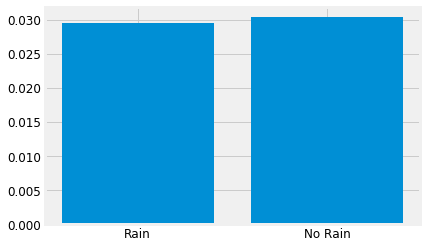

In [45]:
surge_rate_rain = num_rain_surge / (num_rain_surge + num_rain_nosurge)
surge_rate_norain = num_norain_surge / (num_norain_surge + num_norain_nosurge)

print(surge_rate_rain, surge_rate_norain)

plt.bar(x=['Rain', 'No Rain'],
        height=[surge_rate_rain, surge_rate_norain])

# Handle Class Imbalance

## Checking for Class Imbalance

In [323]:
y_train_val.head(1)

30349    0
Name: surge_multiplier, dtype: int64

% of Surge Rides:   0.03%


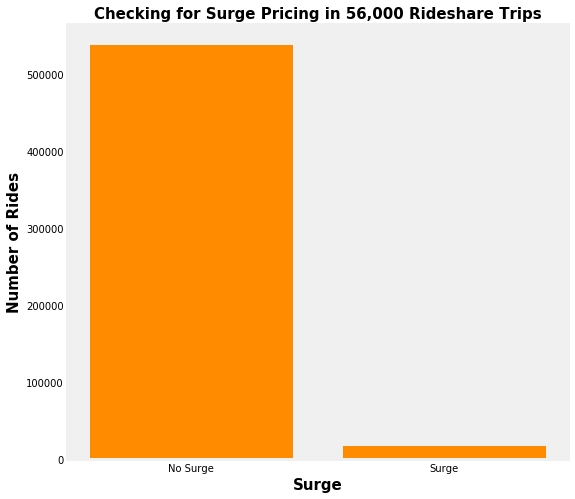

In [37]:
# Check if there's a class imbalance
# Only look at the non-test data

plt.figure(figsize=(8, 8))

plt.title('Checking for Surge Pricing in 56,000 Rideshare Trips', weight='bold', fontsize=15)
plt.xlabel('Surge', weight='bold', fontsize=15)
plt.ylabel('Number of Rides', weight='bold', fontsize=15);

plt.bar(x=['No Surge', 'Surge'],
       height=[np.sum(y_train_val == 0),
              np.sum(y_train_val != 0)],
       color='#FF8C00')

plt.grid(b=None)

ratio_surge_to_no_surge = np.sum(y_train_val != 0) / (np.sum(y_train_val == 0) + np.sum(y_train_val != 0))

print('% of Surge Rides: {:6.2f}%'.format(ratio_surge_to_no_surge))

>As we can see, there are way more "No Surge" occurrences than "Surge"

## Oversamping
Only oversample the training data!
Oversample minority class (1, surge) until it's matched with the majority (0, no surge)

In [17]:
# Concatenate our training data back together
over_sample_train = pd.concat([X_train, y_train], axis=1)

# Separate classes
no_surge = over_sample_train[over_sample_train.surge_multiplier == 0]
surge = over_sample_train[over_sample_train.surge_multiplier == 1]

# Upsample minority class (1, surge)
surge_upsampled = resample(surge,
                          replace=True,  # Sample with replacement
                          n_samples=len(no_surge),  # Match number in majority class
                          random_state=4444)  # Reproducible results

# Combine majority (no_surge) and upsampled minority (surge)
upsampled = pd.concat([no_surge, surge_upsampled])

# Uncomment to check new surge_multiplier counts
# upsampled.surge_multiplier.value_counts()

# Assign upsampled data back to training dataframes
y_train = upsampled.surge_multiplier  # Target is surge_multiplier
X_train = upsampled.drop('surge_multiplier', axis=1)  # Features are all the columns except surge_multiplier

# MVP - Random Forest

Tuning hyperparameters:

In [30]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [31]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, 
#                                cv = 3, 
#                                verbose=2, 
#                                random_state=42, 
#                                n_jobs = -1)

In [43]:
random_forest_model = RandomForestClassifier(criterion='entropy', 
                                             min_samples_leaf=50,
                                             n_estimators=100,
                                             min_samples_split=4,
                                             n_jobs=-1,
                                             oob_score=True,
                                             random_state=0)
random_forest_model.fit(X_train, y_train);

In [ ]:
# rf_random.best_params_

In [44]:
# Get score metrics for Random Forest
print('Random forest validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val, random_forest_model.predict(X_val)), 
         precision_score(y_val, random_forest_model.predict(X_val)), 
         recall_score(y_val, random_forest_model.predict(X_val)),
         f1_score(y_val, random_forest_model.predict(X_val))
        )
     )

Random forest validation metrics: 
 Accuracy: 0.7835 
 Precision: 0.1153 
 Recall: 0.9162 
 F1: 0.2048


In [84]:
# Get score metrics for Random Forest
print('Random forest validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val, predicted), 
         precision_score(y_val, predicted), 
         recall_score(y_val, predicted),
         f1_score(y_val, predicted)
        )
     )

Random forest validation metrics: 
 Accuracy: 0.7488 
 Precision: 0.1046 
 Recall: 0.9601 
 F1: 0.1887


In [81]:
threshold = 0.1

for threshold in np.arange(0, 1, 0.1):

    predicted_proba = random_forest_model.predict_proba(X_val)
    predicted = (predicted_proba [:,1] >= threshold).astype('int')

    print(threshold, roc_auc_score(y_val, predicted))

0.0 0.5
0.1 0.8280897925880386
0.2 0.8370883367751321
0.30000000000000004 0.8459321018360106
0.4 0.8511073405523417
0.5 0.8477618779704723
0.6000000000000001 0.8304341514533196
0.7000000000000001 0.7472894236706565
0.8 0.574704899717428
0.9 0.5028646865435891


In [82]:
threshold = 0.4

predicted_proba = random_forest_model.predict_proba(X_val)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

In [120]:
np.unique(random_forest_model.predict(X_val), return_counts=True)


(array([0, 1]), array([11064,   103]))

In [121]:
np.unique(y_val, return_counts=True)


(array([0, 1]), array([10853,   314]))

## Random Forest - ROC Curve

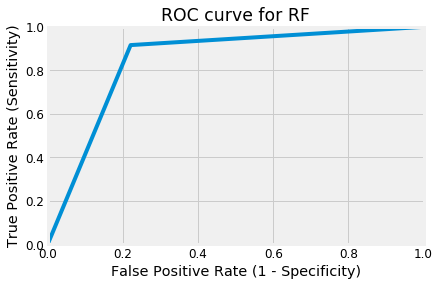

In [85]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob
# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
fpr, tpr, thresholds = roc_curve(y_val, random_forest_model.predict(X_val))

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for RF')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Random Forest - Confusion Matrix

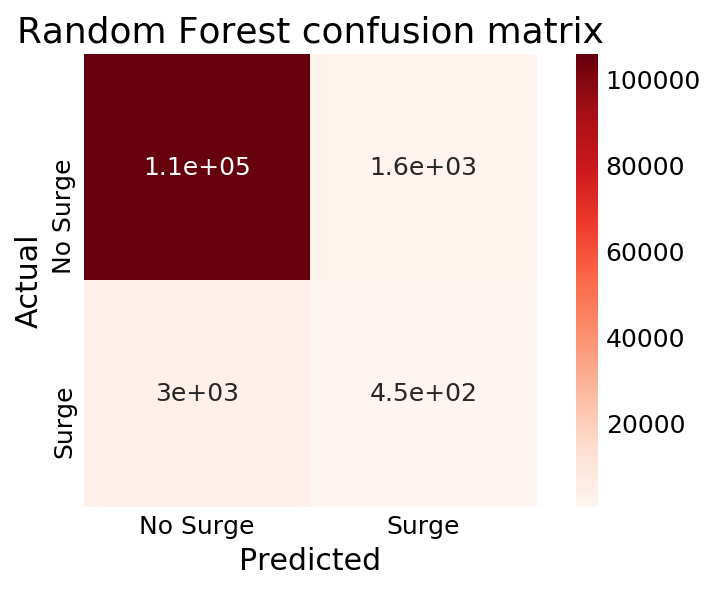

In [16]:
# Print confusion matrix for Random Forest
random_forest_model_confusion = confusion_matrix(y_val, random_forest_model.predict(X_val))
plt.figure(dpi=150)
sns.heatmap(random_forest_model_confusion, cmap=plt.cm.Reds, annot=True, square=True,
           xticklabels=['No Surge', 'Surge'],
           yticklabels=['No Surge', 'Surge'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest confusion matrix');



# MVP - Logestic Regression

In [20]:
logit = LogisticRegression(C = 1)  # Create logistic model. C is inverse regularization term
logit.fit(X_train, y_train);  # Fit model to training data

/Users/samad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
# Get score metrics for Logestic Regression
print('Logestic regression validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val, logit.predict(X_val)), 
         precision_score(y_val, logit.predict(X_val)), 
         recall_score(y_val, logit.predict(X_val)),
         f1_score(y_val, logit.predict(X_val))
        )
     )

Logestic regression validation metrics: 
 Accuracy: 0.7236 
 Precision: 0.0960 
 Recall: 0.9607 
 F1: 0.1746


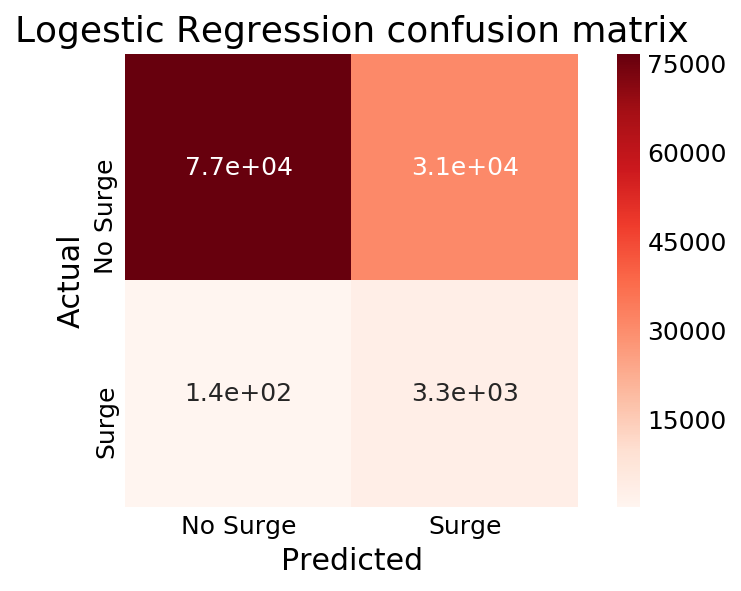

In [20]:
# Print confusion matrix for Random Forest
logit_confusion = confusion_matrix(y_val, logit.predict(X_val))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.Reds, annot=True, square=True,
           xticklabels=['No Surge', 'Surge'],
           yticklabels=['No Surge', 'Surge'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logestic Regression confusion matrix');


# MVP - Naive Bayes

## Naive Bayes - Scores

In [26]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train);

In [27]:
# Get score metrics for Naive Bayes
print('Naive Bayes validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val, nb_model.predict(X_val)), 
         precision_score(y_val, nb_model.predict(X_val)), 
         recall_score(y_val, nb_model.predict(X_val)),
         f1_score(y_val, nb_model.predict(X_val))
        )
     )

Naive Bayes validation metrics: 
 Accuracy: 0.6657 
 Precision: 0.0833 
 Recall: 0.9988 
 F1: 0.1538


# MVP - Decision Tree

## Decision Tree - Scores

In [18]:
decision_tree_model = DecisionTreeClassifier(criterion='gini', random_state=0)
decision_tree_model.fit(X_train, y_train);

In [19]:
# Get score metrics for Decision Tree
print('Decision Tree validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val, decision_tree_model.predict(X_val)), 
         precision_score(y_val, decision_tree_model.predict(X_val)), 
         recall_score(y_val, decision_tree_model.predict(X_val)),
         f1_score(y_val, decision_tree_model.predict(X_val))
        )
     )

Decision Tree validation metrics: 
 Accuracy: 0.9770 
 Precision: 0.6317 
 Recall: 0.5885 
 F1: 0.6093


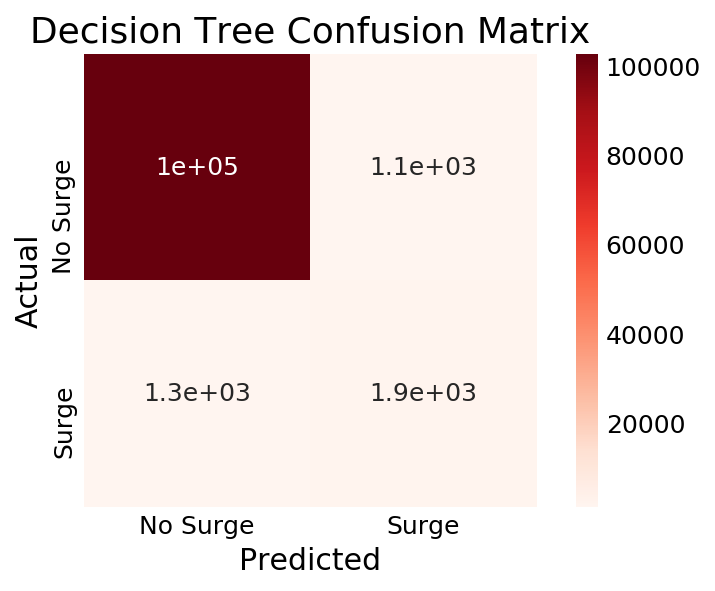

In [97]:
# Print confusion matrix for Random Forest
random_forest_model_confusion = confusion_matrix(y_val, decision_tree_model.predict(X_val))
plt.figure(dpi=150)
sns.heatmap(random_forest_model_confusion, cmap=plt.cm.Reds, annot=True, square=True,
           xticklabels=['No Surge', 'Surge'],
           yticklabels=['No Surge', 'Surge'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix');

# MVP - Gradient Boosting

## Gradient Boosting - Scores

In [24]:
gbm_model = xgb.XGBRegressor( 
                       n_estimators=30000, # Arbitrary large number
                       max_depth=3,
                       objective="reg:linear",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

# gbm_model = xgb.XGBRegressor( 
#                        n_estimators=10000, # Arbitrary large number
#                        max_depth=2,
#                        objective="reg:linear",
#                        learning_rate=.1, 
#                        subsample=1,
#                        min_child_weight=1,
#                        colsample_bytree=.8
#                       )

eval_set = [(X_train, y_train), (X_val, y_val)] # Tracking train/validation error as we go

fit_gbm_model = gbm_model.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=False  # Gives output log as below
                   );

# By default, the XGboost .predict gives us probabilities. So we're rounding to 0 or 1 ( therefore: threshold 0.5)
gbm_model_predictions = [round(value) for value in gbm_model.predict(X_val)]

/Users/samad/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/samad/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:30:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [25]:
# Get score metrics for Gradient Boost
print('Gradient Boost validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_val, gbm_model_predictions), 
         precision_score(y_val, gbm_model_predictions), 
         recall_score(y_val, gbm_model_predictions),
         f1_score(y_val, gbm_model_predictions)
        )
     )

Gradient Boost validation metrics: 
 Accuracy: 0.6935 
 Precision: 0.0889 
 Recall: 0.9807 
 F1: 0.1630


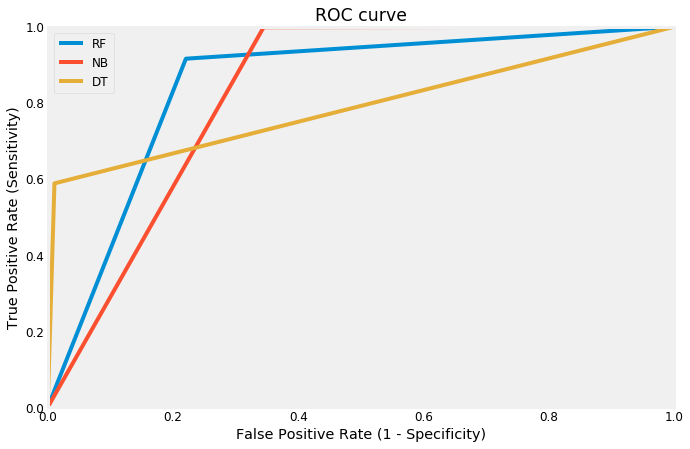

In [95]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob
# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, random_forest_model.predict(X_val))
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, nb_model.predict(X_val))
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, decision_tree_model.predict(X_val))

plt.figure(figsize=(10,7))
plt.plot(fpr_rf, tpr_rf)
plt.plot(fpr_nb, tpr_nb)
plt.plot(fpr_dt, tpr_dt)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(False)
plt.legend(['RF', 'NB', 'DT'])

